### Data exploration and modeling of Find it Fix It requests to the City of Seattle (from a FOI request)

In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("dark")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.text import Text

import gensim
from gensim import corpora


In [2]:
#path for FIFI FOI request
path = 'C:/Users/Schindler/Documents/ProgrammingFun/FIFI/FIFI_data_through_5-12-19.xlsx'

In [3]:
#original file has multiple sheets (for different FIFI types)
whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()
for sheet_name in whole_file.sheet_names:
    sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name))
    print(sheet_name)
    print(sheet_data.columns.values)
    sheet_data['FIFI_category'] = [sheet_name]*sheet_data.shape[0]
    combined_data = pd.concat([combined_data, sheet_data], sort=False)

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.head(1)

['Abandoned Vehicle', 'Clogged Storm Drain', 'Community Walk', 'Dead Animal', 'Graffiti Report', 'Litter-Illegal Dumping-Needles', 'Overgrown Vegetation', 'Parking Enforcement', 'Pothole', 'Sign and Signal Maintenance', 'Streetlight Report', 'Other Inquiry']
Abandoned Vehicle
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'License Number' 'State' 'Vehicle Make' 'Vehicle Color'
 'Length of Time Parked' 'Photo']
Clogged Storm Drain
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Location Details.1' 'Causing property damage?' 'Photo']
Community Walk
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Current Issue' 'Location Details.1' 'Photo']
Dead Animal
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'Description' 'Type of animal' 'On private property?' 'Photo']
Graffiti Report
['Service Request Number' 'Created Date' 'Location' 'Location Details'
 'D

,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,AHZ9829,NaN,Ford,Blue,Over 3 Days,NaN,Abandoned Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(204534, 31)
Litter-Illegal Dumping-Needles    45255
Other Inquiry                     41206
Abandoned Vehicle                 29167
Parking Enforcement               26604
Graffiti Report                   24489
Pothole                           19278
Sign and Signal Maintenance       12219
Streetlight Report                 5631
Name: FIFI_category, dtype: int64
98103    18878
98107    16737
98144    13753
98118    12610
98105    12541
98108    11786
98122    11416
98115     8832
98102     8349
98109     8232
98117     8014
98125     7716
98133     7602
98104     7163
98106     6969
98112     6286
98119     5940
98199     5300
98134     5136
98126     4428
98101     4237
98116     3964
98121     3074
98136     1564
98178     1128
98177     1047
Name: zip, dtype: int64


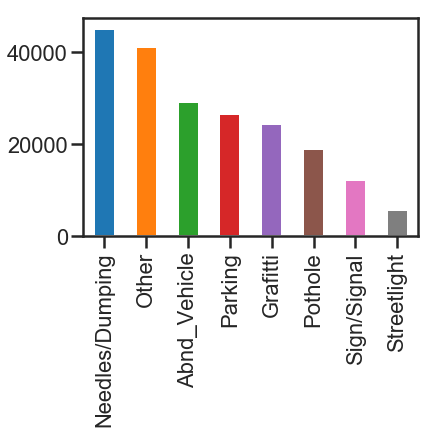

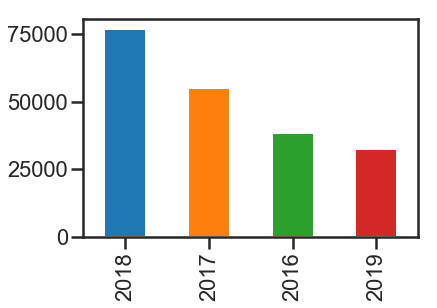

,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue,year,zip
5994,16-00000050,2016-01-01 10:17:27,"5900 34TH CT S, SEATTLE, WA 98118","5900 34TH CT S; XY: 1280854.342623405, 203954....","Gold car, appears to have a window that won't ...",065-XVB,WA,Mercedes-Benz,Other,Over 1 month,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,98118


In [4]:
#clean and preprocess data

#create year column 
combined_data['year'] = combined_data['Created Date'].dt.year

#select data that includes a zip code (starting with 2015)
combined_data_2015 = combined_data[combined_data['Created Date'].dt.year > 2015]
print(combined_data_2015.shape)

#select FIFI categories that have great than 999 entries
cat_counts = combined_data_2015['FIFI_category'].value_counts()
cat_counts_1000 = cat_counts[cat_counts > 999].index.values
combined_data_final = combined_data_2015[combined_data_2015['FIFI_category'].isin(cat_counts_1000)]
print(combined_data_final['FIFI_category'].value_counts())  

#create new column with zip code
combined_data_final['zip'] = combined_data_final.apply(lambda row: row['Location'].split()[-1], axis=1)  

#select zips that have great than 999 entries
zip_counts = combined_data_final['zip'].value_counts()
zip_counts_1000 = zip_counts[zip_counts > 999].index.values
combined_data_final = combined_data_final[combined_data_final['zip'].isin(zip_counts_1000)]
print(combined_data_final['zip'].value_counts()) 

#update FIFI_cat names
combined_data_final.replace({'Litter-Illegal Dumping-Needles': 'Needles/Dumping', 
                             'Other Inquiry': 'Other',
                             'Abandoned Vehicle': 'Abnd_Vehicle',
                             'Parking Enforcement': 'Parking',
                             'Graffiti Report': 'Grafitti',
                             'Sign and Signal Maintenance': 'Sign/Signal',
                             'Streetlight Report': 'Streetlight'}, inplace=True)

#viz FIFI requests by category
combined_data_final['FIFI_category'].value_counts().plot(kind='bar')
plt.show()

#viz FIFI requests by year
combined_data_final['year'].value_counts().plot(kind='bar')
plt.show()

combined_data_final.head(1)

In [5]:
zip_neighborhood_dic = {'98028': 'Kenmore', 
                        '98031': 'Kent',
                        '98057': 'Renton',
                        '98101': 'Dt/FirstH', 
                        '98102': 'Cap_Hill', 
                        '98103': 'GnWd/Frmt/GnLk', 
                        '98104': 'PioneerS/FirstH',
                        '98105': 'Udist/LarHur', 
                        '98106': 'Delridge',
                        '98107': 'Ballard', 
                        '98108': 'South_Park',
                        '98109': 'Westlake',
                        '98112': 'Madison_Park',
                        '98115': 'Wedgewood',
                        '98116': 'WestS_Alki', 
                        '98117': 'Ballard',
                        '98118': 'ColCity/SewardP', 
                        '98119': 'Queen_Anne',
                        '98121': 'Belltown',
                        '98122': 'Leschi',
                        '98125': 'Northgate', 
                        '98126': 'Delridge',
                        '98133': 'Bitterlake',
                        '98134': 'Harbor_Island',
                        '98136': 'Fauntleroy',
                        '98144': 'MtBaker', 
                        '98146': 'Arbor_Heights',
                        '98148': 'Sunnydale',
                        '98155': 'North_City',
                        '98164': 'DT_library',
                        '98166': 'Gregory_Heights',
                        '98168': 'Burien',
                        '98177': 'LoyalH/Highlands',
                        '98178': 'Lakeridge',
                        '98188': 'SeaTac',
                        '98195': 'UW_campus',
                        '98199': 'Magnolia'}

zip_list = list(zip_neighborhood_dic.keys())
zip_filtered = combined_data_final[combined_data_final['zip'].isin(zip_list)]
print(zip_filtered.shape)

zip_filtered['neighborhood'] = zip_filtered.apply(lambda row: zip_neighborhood_dic[row['zip']], axis=1)

zip_filtered.head(1)

(202702, 32)


,Service Request Number,Created Date,Location,Location Details,Description,License Number,State,Vehicle Make,Vehicle Color,Length of Time Parked,Photo,FIFI_category,Location Details.1,Causing property damage?,Current Issue,Type of animal,On private property?,What is the Graffiti on?,Location and Description,"Obscene, racial, or hateful?",Cross street or intersection?,Where?,Type of item?,Where is the vegetation growing,Vegetation Safety Issue,Parking Violation Concerning,License Plate Number,Location details,7 digit number on pole,Issue,year,zip,neighborhood
5994,16-00000050,2016-01-01 10:17:27,"5900 34TH CT S, SEATTLE, WA 98118","5900 34TH CT S; XY: 1280854.342623405, 203954....","Gold car, appears to have a window that won't ...",065-XVB,WA,Mercedes-Benz,Other,Over 1 month,http://servicerequest.seattle.gov/media/seattl...,Abnd_Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,98118,ColCity/SewardP


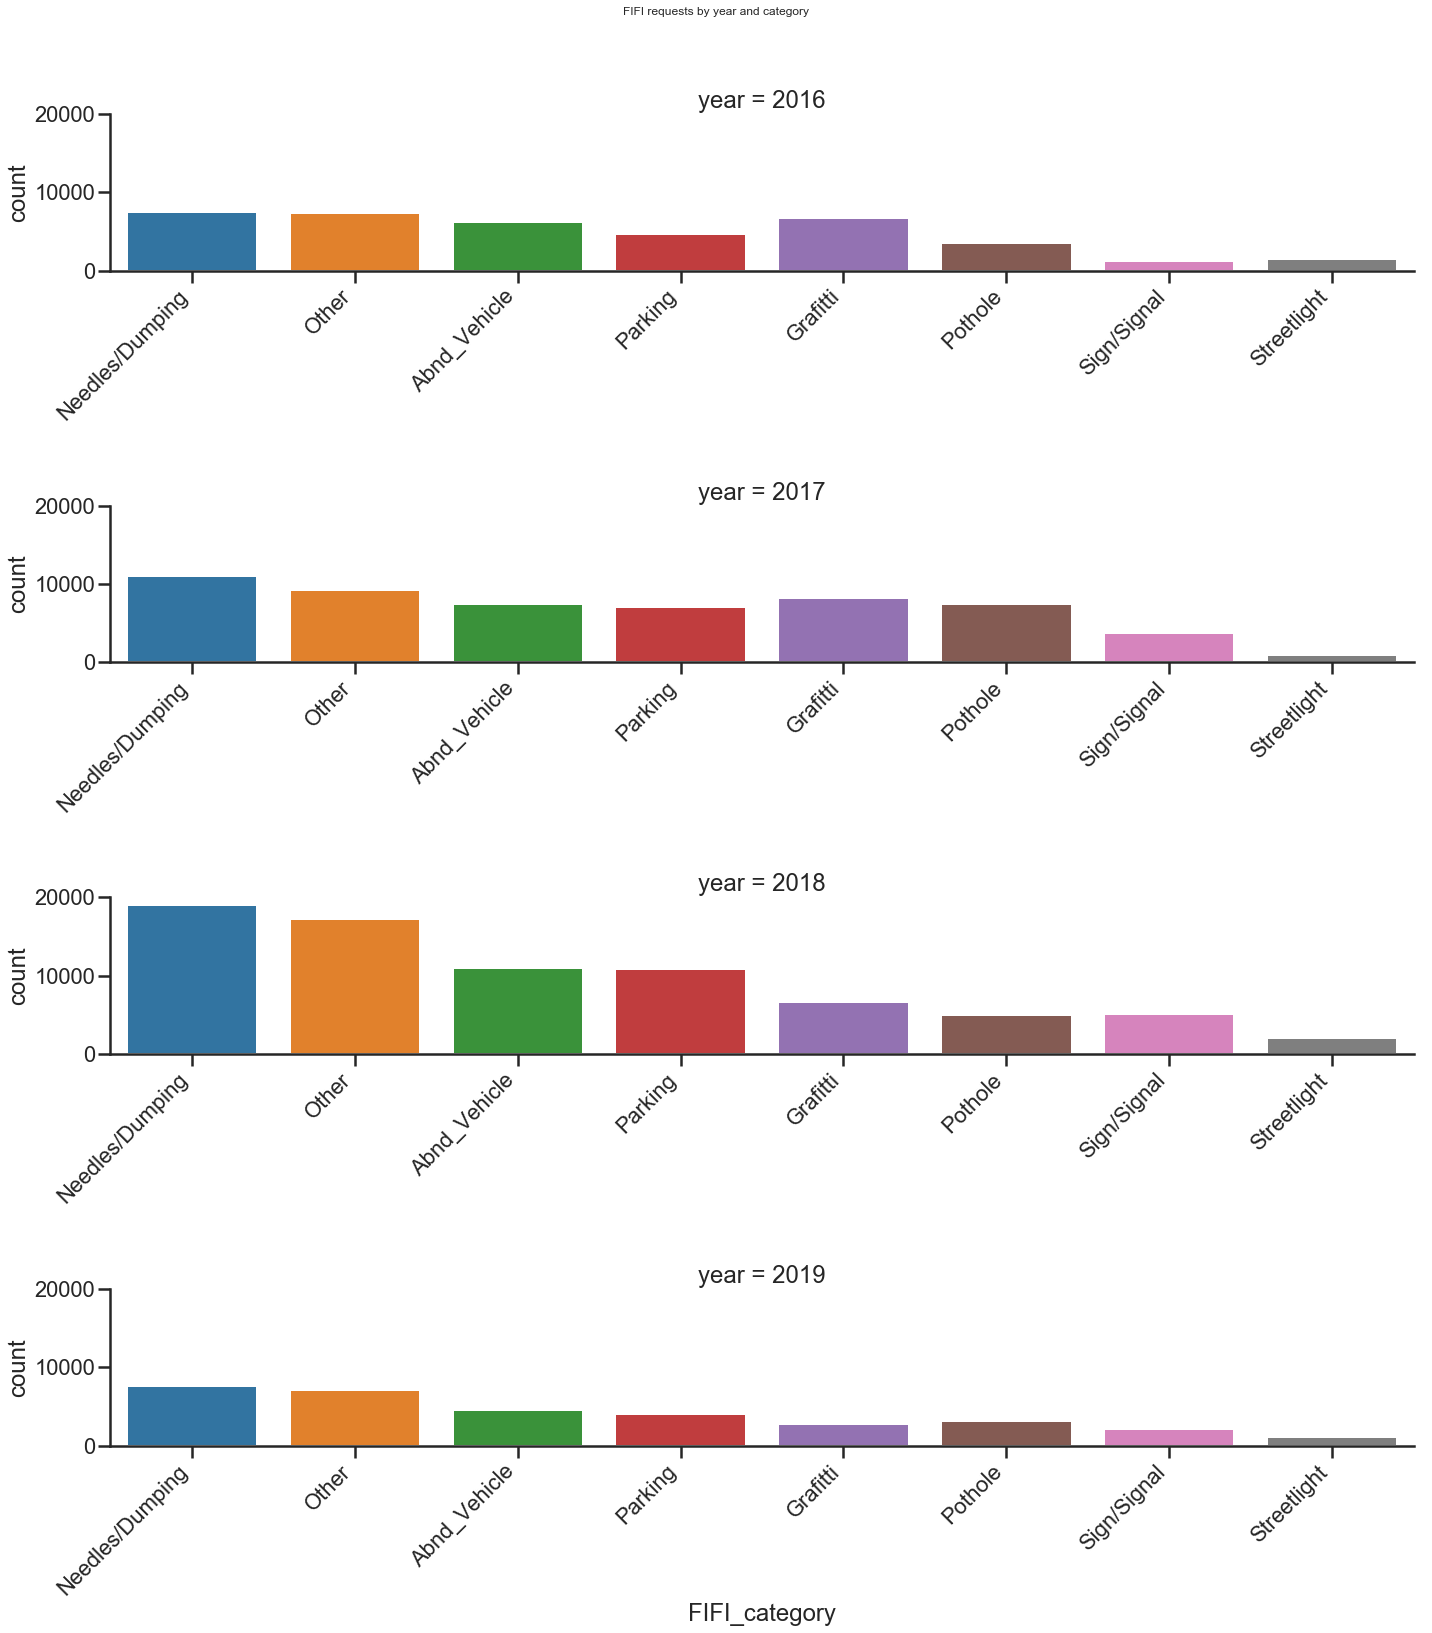

In [9]:
#create list of cats ordered by request count to use for ordering of x axis on graphs
cat_order = zip_filtered['FIFI_category'].value_counts().index.values

#create and viz number of FIFI requests by year and category
year_cat_count = zip_filtered.groupby(['year', 'FIFI_category'])['FIFI_category'].count().reset_index(name='count')

g = sns.catplot(x='FIFI_category', data=year_cat_count, y='count', kind='bar', ci=68, height=5, aspect=4, \
                col='year', col_wrap=1, sharex=False, order=cat_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year and category', y=1.05)
plt.subplots_adjust(hspace = 1.5)

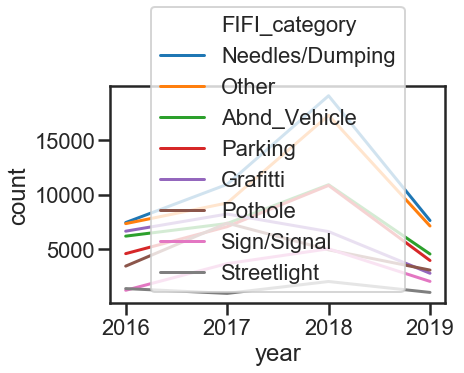

In [7]:
g = sns.lineplot(x='year', data=year_cat_count, y='count', ci=68, hue='FIFI_category')
#Lars says use percent change from 2016 (as baseline) and then look at change over time, do by month (is it seasonal)
#Lars asks about commercial vs residential

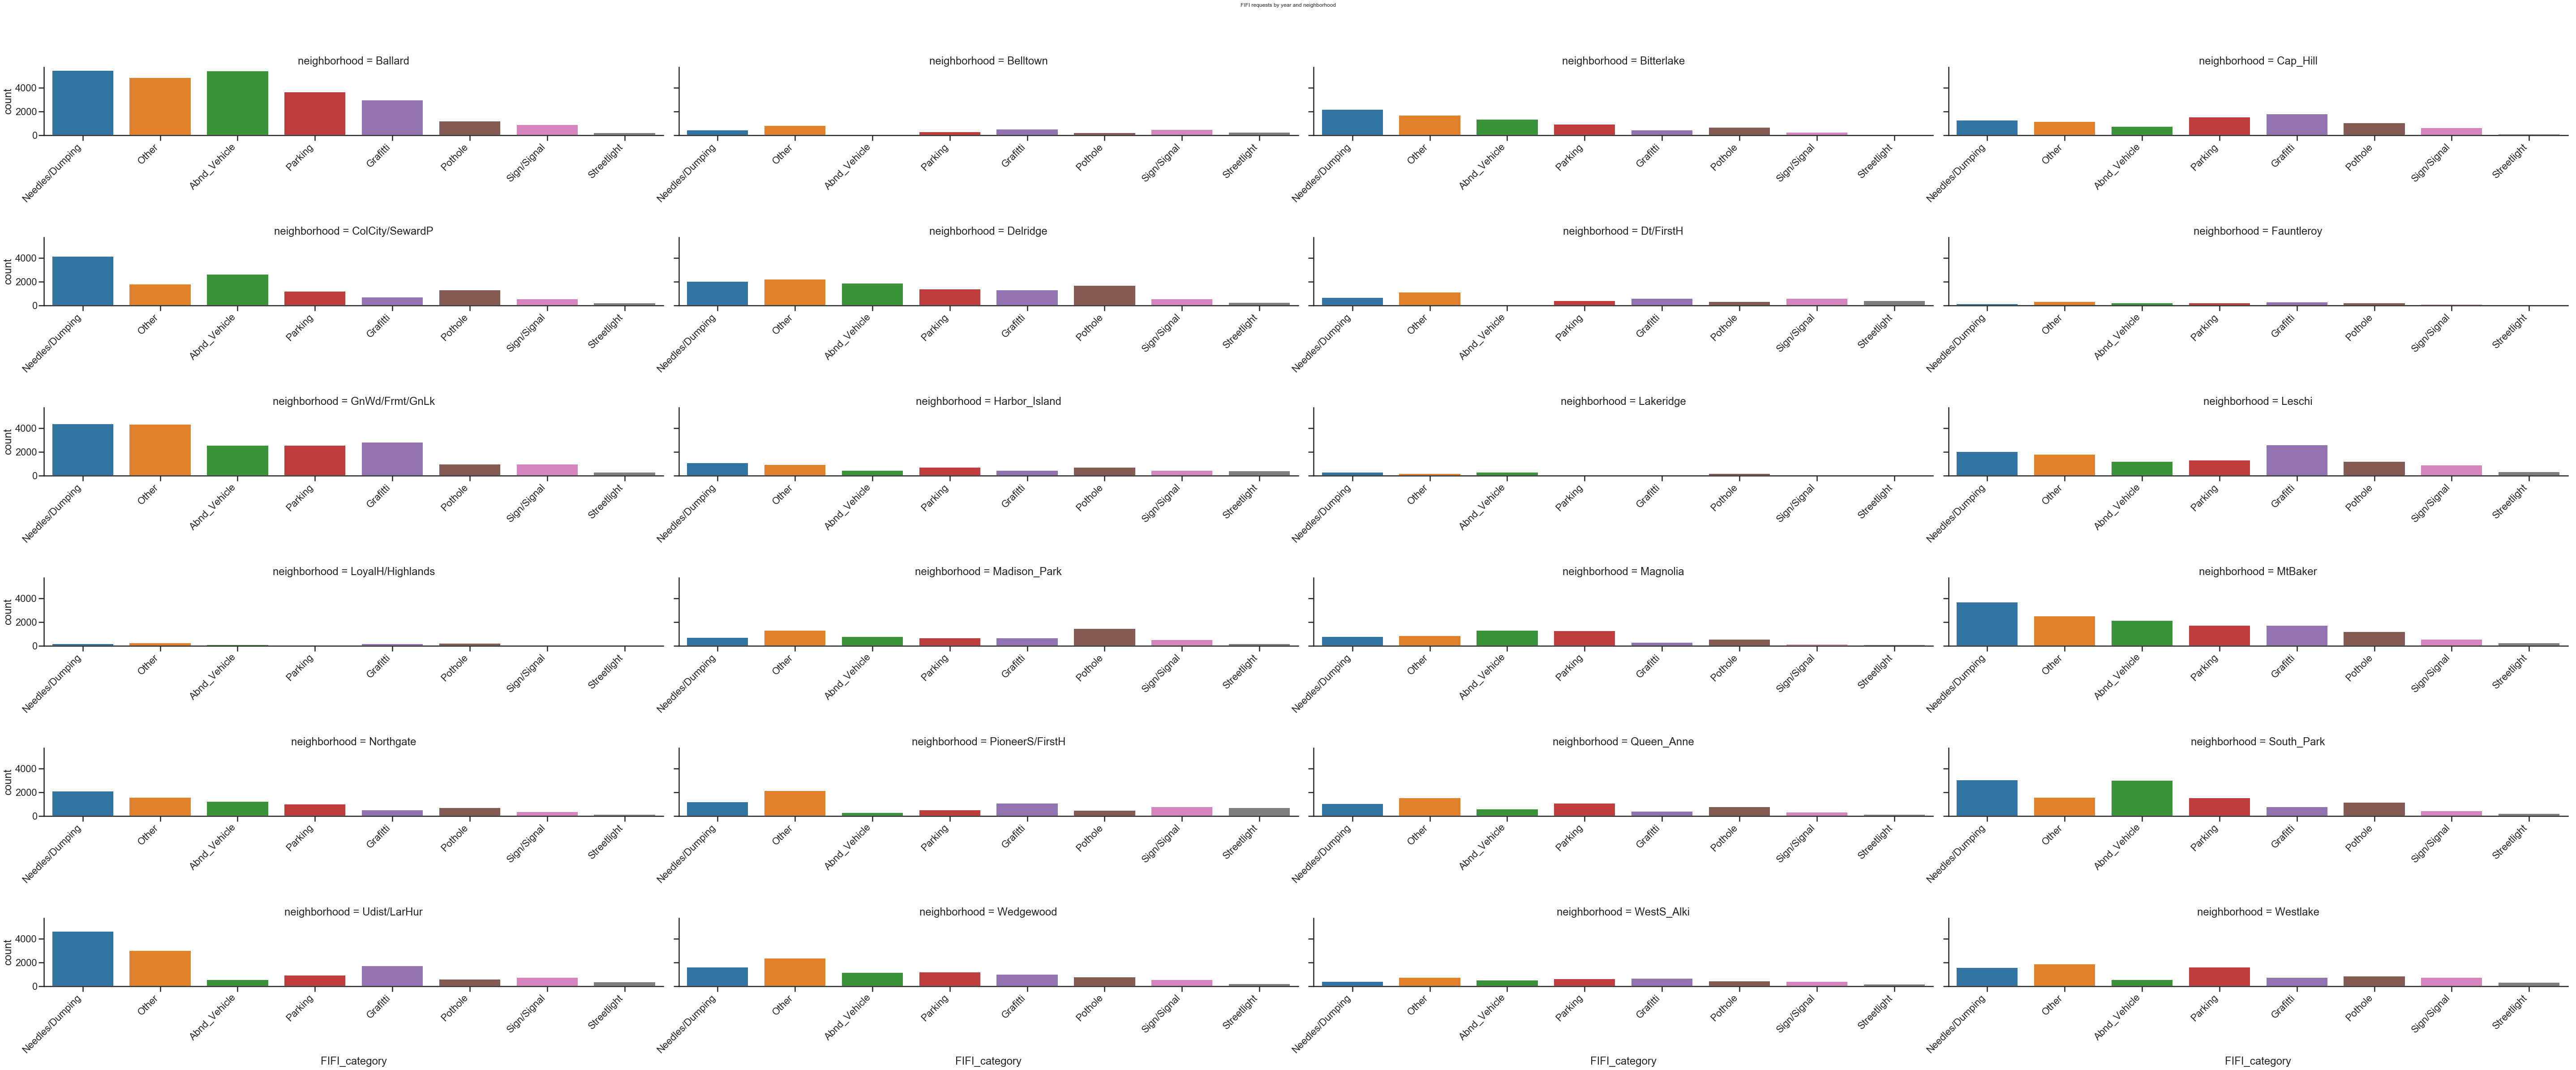

In [16]:
#create and viz number of FIFI requests by neighborhood and category
cat_neigh_count = zip_filtered.groupby(['FIFI_category', 'neighborhood'])['FIFI_category'].count().reset_index(name='count')

g = sns.catplot(x='FIFI_category', data=cat_neigh_count, y='count', kind='bar', ci=68, height=5, aspect=4, \
                col='neighborhood', col_wrap=4, sharex=False, order=cat_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year and neighborhood', y=1.05)
plt.subplots_adjust(hspace = 1.5)

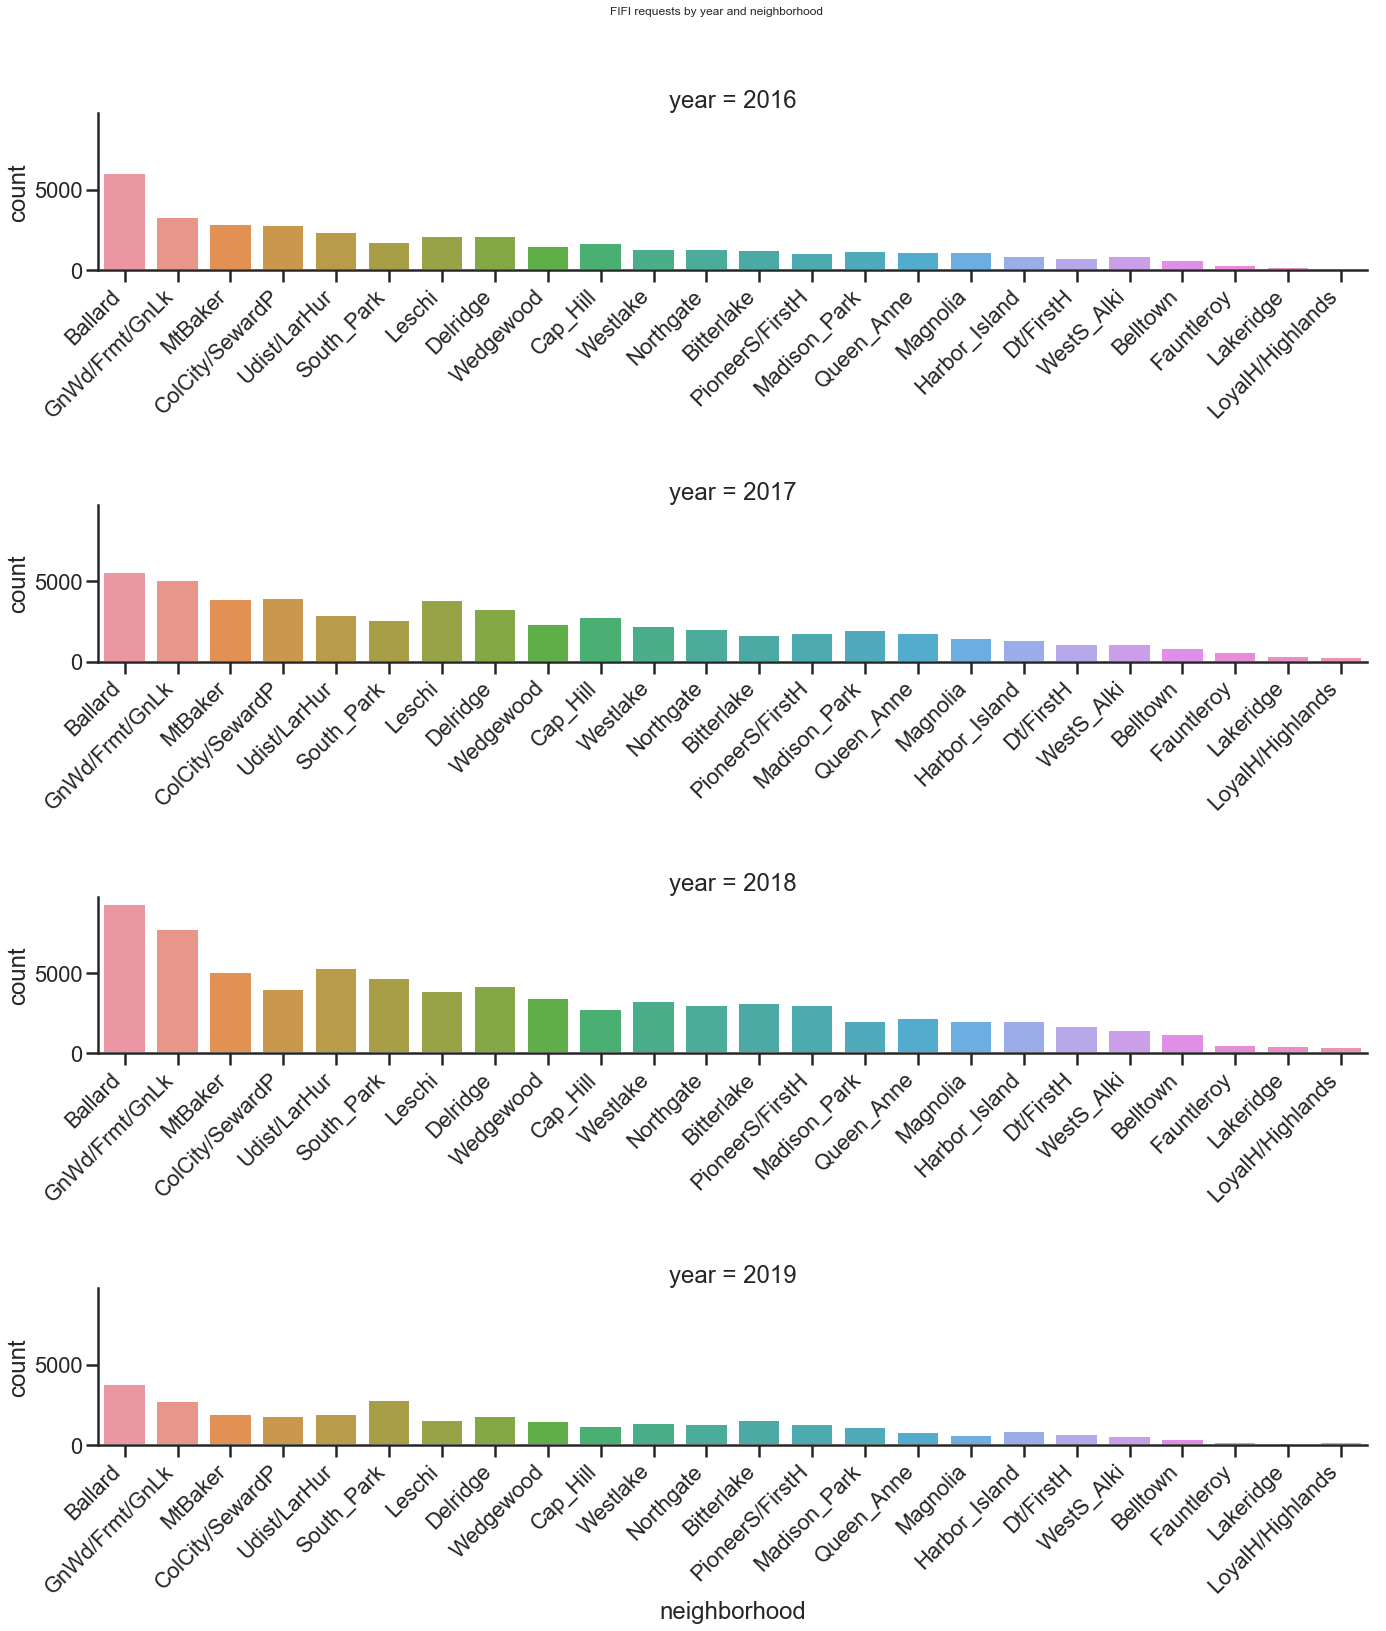

In [8]:
#create list of neighborhoods ordered by request count to use for ordering of x axis on graphs
neigh_order = zip_filtered['neighborhood'].value_counts().index.values

#create and viz number of FIFI requests by neighborhood and year
year_neigh_count = zip_filtered.groupby(['year', 'neighborhood'])['FIFI_category'].count().reset_index(name='count').sort_values('count', ascending=False)

g = sns.catplot(x='neighborhood', data=year_neigh_count, y='count', kind='bar', ci=68, height=5, aspect=4, \
                col='year', col_wrap=1, sharex=False, order=neigh_order)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('FIFI requests by year and neighborhood', y=1.05)
plt.subplots_adjust(hspace = 1.5)

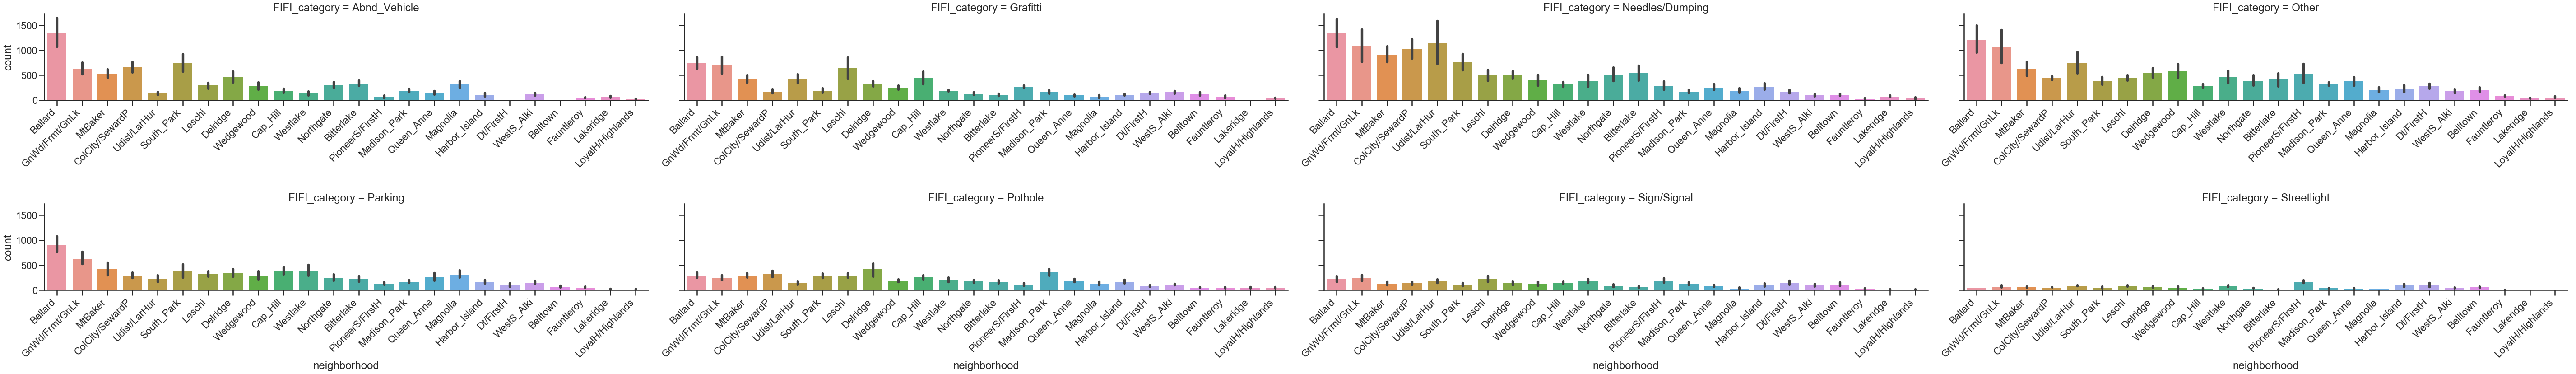

In [15]:
#create and viz number of FIFI requests by year, neighborhood, and category
year_neigh_cat_count = zip_filtered.groupby(['year', 'neighborhood', 'FIFI_category'])['FIFI_category'].count().reset_index(name='count')

g = sns.catplot(x='neighborhood', data=year_neigh_cat_count, y='count', kind='bar', ci=68, height=5, aspect=4, \
                col='FIFI_category', col_wrap=4, sharex=False, order=neigh_order)
g.set_xticklabels(rotation=45, ha='right')
plt.subplots_adjust(hspace = 1.2)

In [ ]:
#sentiment analysis with nltk
#preprocess first

print(zip_filtered.shape)
zip_filtered_note = zip_filtered[~zip_filtered['Description'].isna()]
print(zip_filtered_note.shape)

#remove punctuation, lowercase words
print('removing punctuation and making lowercase')
zip_filtered_note['entry_clean'] = zip_filtered_note.apply(lambda row: re.sub(r'[^\w\s]','', row['Description']), axis=1)
zip_filtered_note['entry_clean'] = zip_filtered_note['entry_clean'].str.lower()

#tokenize each entry
print('tokenizing')
zip_filtered_note['entry_clean'] = zip_filtered_note.apply(lambda row: word_tokenize(row['entry_clean']), axis=1)

#remove words with fewer than 3 characters

#remove stop words
print('removing stop words')
stop_words=set(stopwords.words("english"))
zip_filtered_note['entry_clean'] = [[w for w in row if w not in stop_words] for row in zip_filtered_note['entry_clean']]

#lemmatize
print('lemmatizing')
lemmatizer = WordNetLemmatizer()
zip_filtered_note['entry_clean'] = [[lemmatizer.lemmatize(w) for w in row] for row in zip_filtered_note['entry_clean']]

# Stemming
print('stemming')
ps = PorterStemmer()
zip_filtered_note['entry_clean'] = [[ps.stem(w) for w in row] for row in zip_filtered_note['entry_clean']]

#part of speech assign
#x = nltk.pos_tag(x)

In [ ]:
zip_filtered_note['FIFI_category'].value_counts()

In [ ]:
# Create dictionary
dictionary = corpora.Dictionary(zip_filtered_note['entry_clean'].values)
print(dictionary)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

#filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.1)

#create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in zip_filtered_note['entry_clean']]

document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print(bow_doc_x[i][0])
    print(dictionary[bow_doc_x[i][0]])
    print(bow_doc_x[i][1])
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

In [ ]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2, alpha = 0.001)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

In [ ]:
#use sentiment.vader to get polarity score of each entry
sid = SentimentIntensityAnalyzer()
x_polarity_sum = []
x_polarity_min = []
x_polarity_max = []
for index, row in zip_filtered_note.iterrows():
    polarity_list = [sid.polarity_scores(w)['compound'] for w in row['entry_clean']]
    x_polarity_sum.append(sum(polarity_list))
    try:
        x_polarity_min.append(min(polarity_list))
    except: 
        x_polarity_min.append(np.nan)
    try:
        x_polarity_max.append(max(polarity_list))
    except: 
        x_polarity_max.append(np.nan)
    
#zip_filtered_note['x_polarity'] = zip_filtered_note.apply(lambda row: sid.polarity_scores(w)['compound'] for w in row['entry_clean'], axis=1)
#zip_filtered_note['x_polarity'] = zip_filtered_note.apply(lambda row: sum(row['x_polarity']))
#x_polarity = [sid.polarity_scores(w)['compound'] for w in x]
zip_filtered_note['x_polarity_sum'] = x_polarity_sum
zip_filtered_note['x_polarity_min'] = x_polarity_min
zip_filtered_note['x_polarity_max'] = x_polarity_max

In [ ]:
sns.catplot(x='neighborhood', y='x_polarity_min', data=zip_filtered_note, col='FIFI_category', kind='bar', col_wrap=4, height=10, order=other_highest_neigh_list)

In [ ]:
sns.catplot(x='FIFI_category', y='x_polarity_min', data=zip_filtered_note, kind='bar', height=10, aspect=2)